In [12]:
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Input, Dropout, Dense, RepeatVector, TimeDistributed
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
sns.set_style("dark")
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/home/guilherme/anaconda3/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [2]:
# Load data
dataframe = pd.read_csv('GE.csv')
df = dataframe[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])

/home/guilherme/anaconda3/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


/home/guilherme/anaconda3/envs/tfgpu/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


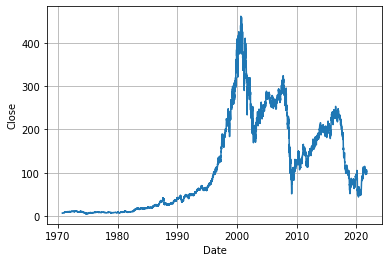

In [3]:
# debug
sns.lineplot(x=df['Date'], y=df['Close'])
plt.grid('on')
plt.show()

In [4]:
train, test = df.loc[df['Date'] <= '2003-12-31'], df.loc[df['Date'] > '2003-12-31']

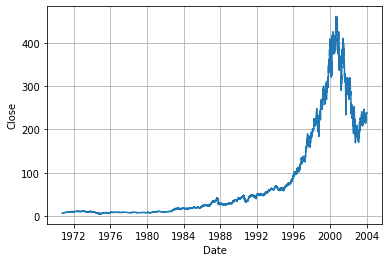

In [5]:
# debug
sns.lineplot(x=train['Date'], y=train['Close'])
plt.grid('on')
plt.show()

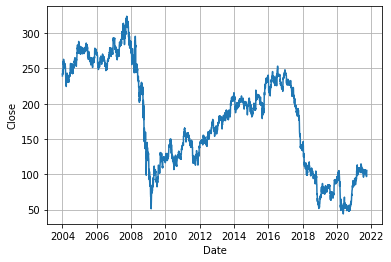

In [6]:
# debug
sns.lineplot(x=test['Date'], y=test['Close'])
plt.grid('on')
plt.show()

In [7]:
# preprocessing the data
# LSTM use sigmoid and tanh so the values must needs to be normalize
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

/home/guilherme/anaconda3/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/guilherme/anaconda3/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [8]:
# As required for LSTM, we require to reshape an input data into n_samples x timesteps x n_features
# In this example n_features = 2; timesteps = 3; n_sample = 5; 5*2*3=30
seq_size = 30  # Number of timesteps to look back


##x is the senquency of 30 data points
## y is the 31 data point
def to_sequence(x, y, seq_size=1):
    x_values = []
    y_values = []
    for i in range(len(x)-seq_size):
        x_values.append(x.iloc[i:(i + seq_size)].values)
        y_values.append(y.iloc[i + seq_size])

    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequence(train[['Close']], train[['Close']], seq_size)
testX, testY = to_sequence(test[['Close']], test[['Close']], seq_size)

In [9]:
## use 30 data point to rpedict the next one
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))


model.compile(optimizer='adam', loss='mae')
model.summary()

history = model.fit(trainX, trainY, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

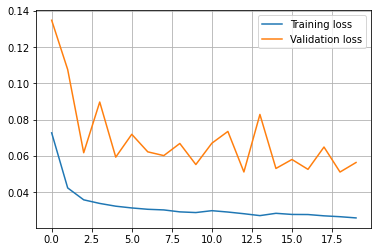

In [10]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.grid('on')
plt.show()

(array([6.182e+03, 5.560e+02, 2.890e+02, 2.900e+02, 2.510e+02, 1.920e+02,
        1.260e+02, 1.440e+02, 8.200e+01, 6.400e+01, 4.400e+01, 3.300e+01,
        2.300e+01, 2.600e+01, 2.200e+01, 1.600e+01, 8.000e+00, 4.000e+00,
        4.000e+00, 2.000e+00, 4.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([0.00191758, 0.02501735, 0.04811712, 0.07121688, 0.09431665,
        0.11741642, 0.14051619, 0.16361596, 0.18671572, 0.20981549,
        0.23291526, 0.25601503, 0.2791148 , 0.30221457, 0.32531433,
        0.3484141 , 0.37151387, 0.39461364, 0.41771341, 0.44081318,
        0.46391294, 0.48701271, 0.51011248, 0.53321225, 0.55631202,
        0.57941179, 0.60251155, 0.62561132, 0.64871109, 0.67181086,
        0.69491063]),
 <a list of 30 Patch objects>)

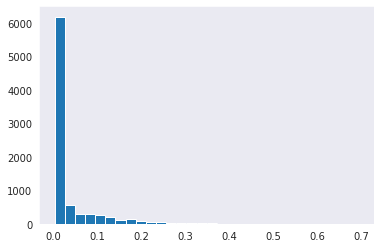

In [14]:
train_predict = model.predict(trainX)
train_mae = np.mean(np.abs(train_predict - trainX),axis=1)
plt.hist(train_mae, bins=30)

In [19]:
threshold = np.mean(train_mae) + 3*np.std(train_mae)
threshold

0.22468293008788484

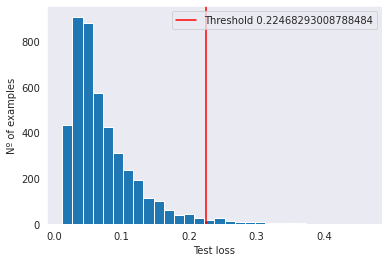

In [20]:
test_predict = model.predict(testX)
test_mae = np.mean(np.abs(test_predict - testX),axis=1)
plt.hist(test_mae, bins=30)
plt.axvline(threshold, c='r', label=f'Threshold {threshold}')
plt.xlabel('Test loss')
plt.ylabel('Nº of examples')
plt.legend()